#Computer vision final project - Font classification
##Name: Noam Sadeh
##Date 5.2.2023

##Importing libraries 📚

In [3]:
# deep learning libraries:
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json,  save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import random_contrast, random_brightness, random_saturation, random_hue
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2

#data visualization:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# data preprocessing:
import seaborn as sns
import numpy as np
import cv2
import h5py
import os
from pathlib import Path
from PIL import Image
from collections import defaultdict
from sklearn.metrics import accuracy_score
import json
import pandas as pd

##Loading the dataset


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
db = h5py.File('/content/drive/MyDrive/SynthText_train.h5')
im_names = list(db['data'].keys())

##Preprocessing: 📊

In [7]:
#this function cuts the image to 64x64 pixels
def concentrateImg(src_img, src_BB, target_BB_res=(44,44), hmargin=10, vmargin=10):
    # target boundry box (for the homography)
    target_BB = np.array([[hmargin, vmargin],
                          [hmargin + target_BB_res[0], vmargin],
                          [hmargin + target_BB_res[0], vmargin + target_BB_res[1]],
                          [hmargin, vmargin + target_BB_res[1]]]).transpose()
    # resolution of the target concentrated image (including margins)
    target_img_res = (2 * hmargin + target_BB_res[0],
                      2 * vmargin + target_BB_res[1])
    # calculate the homography from original BB to target BB
    H = cv2.findHomography(src_BB.transpose(), target_BB.transpose())[0]
    H = cv2.warpPerspective(src_img, H, target_img_res)
    img = Image.fromarray(H)
    return img

###count fonts

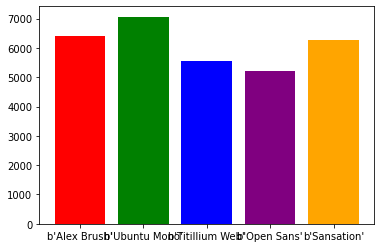

In [ ]:
count_fonts = {"b'Alex Brush'" : 0, "b'Ubuntu Mono'" : 0, "b'Titillium Web'" : 0, "b'Open Sans'" : 0, "b'Sansation'" : 0}
alex_counter = 0
ubuntu_counter = 0
titillium_counter = 0
open_counter = 0
sansation_counter = 0

for img in im_names:
  font = db['data'][img].attrs['font']
  for name in font:
    count_fonts[str(name)] += 1

plt.bar(list(count_fonts.keys()), count_fonts.values(), color=['red', 'green', 'blue', 'purple' , 'orange'])
plt.show()

###Creating folders 📁

In [ ]:
directories = ['/content/train_set', '/content/test_set']
paths = ['Alex Brush/', 'Ubuntu Mono', 'Open Sans','Titillium Web', 'Sansation']
             
for directory in directories:
  os.mkdir(directory)
  for path in paths:  # creating directories
    os.mkdir(os.path.join(directory,path))

##split data set to test, validation, test

In [ ]:
num = 0 # counter for setting the name of the file
image_counter = 0 # for spliting train and test
letter_counter = defaultdict(int)

for im in im_names:
  i = 0
  img = db['data'][im][:]
  font = db['data'][im].attrs['font']
  txt = db['data'][im].attrs['txt']
  charBB = db['data'][im].attrs['charBB']

  for word in txt:
    for letter in word:
      try:
        letter_counter[chr(letter)] += 1
        new_img = concentrateImg(img, charBB[:, :, i])
        curr_font = font[i].decode('UTF-8')
        file_name = chr(letter) + str(num) +'.bmp'   

        if image_counter < round(len(im_names) * 0.8):
          path = "/content/train_set/{}/{}".format(curr_font, file_name)
        else:
          path = "/content/test_set/{}/{}".format(curr_font, file_name)
        new_img.save(path, "BMP")
      except:
        pass
      i += 1
      num += 1
  image_counter += 1

##Building and training the neural network

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255)

train_dataset = training_generator.flow_from_directory('/content/train_set',
                                                        target_size = (64,64),
                                                        class_mode = 'categorical',                                                     
                                                        shuffle = True)
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/test_set',
                                                     target_size = (64,64),
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 24318 images belonging to 5 classes.
Found 6176 images belonging to 5 classes.


In [10]:
class RandomColorDistortion(tf.keras.layers.Layer):

    def __init__(self, contrast_range=(1,6), brighness_range=(0.5,1.5), saturation_range=(0.5,1.5), hue_delta=0.5, **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brighness_range = brighness_range
        self.saturation_range = saturation_range
        self.hue_delta = hue_delta

    def get_config(self):
      cfg = super().get_config()
      return cfg 
         
    def call(self, images, training=None):
        if training:
          images = random_contrast(images, self.contrast_range[0], self.contrast_range[1])
          images = random_brightness(images, self.brighness_range[0], self.brighness_range[1])
          images = random_saturation(images, self.saturation_range[0], self.saturation_range[1])
          images = random_hue(images, self.hue_delta)
          images = tf.clip_by_value(images, 0, 1)
        return images

In [ ]:
model = Sequential([
InputLayer(input_shape=(64,64,3)),
RandomColorDistortion(name='randomcolordistortion'),
    
Conv2D(filters=64,kernel_size=(9,9), kernel_regularizer=l2(0.0005), activation=LeakyReLU(alpha=0.5), padding='same'),
MaxPooling2D(pool_size=(2,2)),
    
Conv2D(filters=32,kernel_size=(6,6), activation=LeakyReLU(alpha=0.1)),
BatchNormalization(),
MaxPooling2D(pool_size=(2,2)),
Dropout(0.25),
    
Conv2D(filters=64,kernel_size=(3,3), activation=LeakyReLU(alpha=0.1)),
MaxPooling2D(pool_size=(2,2)),
Dropout(0.25),
    
Flatten(),
Dense(128, activation=LeakyReLU(alpha=0.1)),
Dropout(0.25),
Dense(128, activation=LeakyReLU(alpha=0.1)),
Dropout(0.25),
Dense(5, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 randomcolordistortion (Rand  (None, 64, 64, 3)        0         
 omColorDistortion)                                              
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        73760     
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                        

###Loss and Optimizer
The loss is Cross Entropy - ment for multiclass classification.

The optimizer is adam

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
lr_decay = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, mode="auto",
                                         verbose=1, min_delta=0.0001,cooldown=0, min_lr=0)
mcp_save = ModelCheckpoint('/content/model/model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train_dataset, epochs=110,
                validation_data=test_dataset, callbacks=[lr_decay, mcp_save])

Epoch 1/110
760/760 [==============================] - 24s 20ms/step - loss: 1.3455 - accuracy: 0.4021 - val_loss: 1.1274 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 2/110
760/760 [==============================] - 14s 18ms/step - loss: 1.0129 - accuracy: 0.5648 - val_loss: 1.0066 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 3/110
760/760 [==============================] - 14s 18ms/step - loss: 0.8943 - accuracy: 0.6242 - val_loss: 0.7910 - val_accuracy: 0.6728 - lr: 0.0010
Epoch 4/110
760/760 [==============================] - 14s 18ms/step - loss: 0.8393 - accuracy: 0.6552 - val_loss: 0.7296 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 5/110
760/760 [==============================] - 16s 21ms/step - loss: 0.7866 - accuracy: 0.6767 - val_loss: 0.6661 - val_accuracy: 0.7340 - lr: 0.0010
Epoch 6/110
760/760 [==============================] - 23s 30ms/step - loss: 0.7463 - accuracy: 0.7010 - val_loss: 0.6479 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 7/110
760/760 [==============================]

###Save the model structure

In [ ]:
model_json = model.to_json()
with open('/content/model/model.json','w') as json_file:
  json_file.write(model_json)

##Evaluating the model

###Visualize history log:
this will show us the optimiztion of the validation loss in this model.

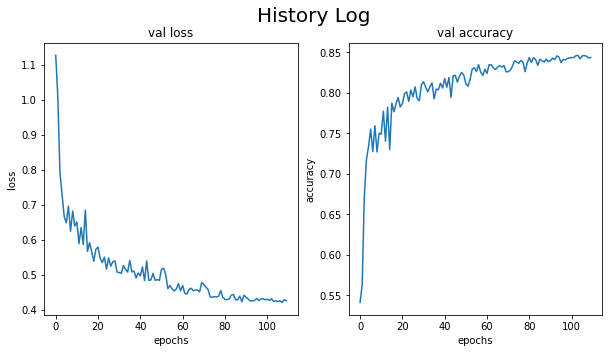

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)

axs[0].plot(history.history['val_loss'])
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].set_title('val loss')

axs[1].plot(history.history['val_accuracy'])
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].set_title('val accuracy')

plt.show()

The log clearly shows the epoch chosen was right before the model could overfit.

In [ ]:
predictions = model.predict(test_dataset)

193/193 [==============================] - 2s 10ms/step


In [ ]:
predictions = np.argmax(predictions, axis = 1)
global_model_performance = accuracy_score(test_dataset.classes, predictions)
print(global_model_performance)

0.84375


##Optimization

In [1]:
# convert number to the name of the class
def find_name(num):
  if num == 0:
    return 'Alex Brush'
  if num == 1:
    return 'Open Sans'
  if num == 2:
    return 'Sansation'
  if num == 3:
    return 'Titillium Web'
  return 'Ubuntu Mono'

### Loading the model

In [11]:
with open('model/model.json', 'r') as json_file:
  json_model = json_file.read()
model = model_from_json(json_model, custom_objects={'RandomColorDistortion': RandomColorDistortion})
model.load_weights('model/model.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### calculates success probabilty for each char

In [ ]:
train_images_len = round(len(im_names) * 0.8)

success_letters = defaultdict(int)
fail_letters = defaultdict(int)

for im in im_names[:train_images_len]: # only the train set
  i = 0
  img = db['data'][im][:]
  font = db['data'][im].attrs['font']
  txt = db['data'][im].attrs['txt']
  charBB = db['data'][im].attrs['charBB']
  for word in txt:
    real_font = font[i].decode('UTF-8')
    for letter in word:
      try:
        # preprocces the image
         proccessed_img = np.array(concentrateImg(img, charBB[:, :, i]))
         proccessed_img =  proccessed_img / 255
         proccessed_img =  proccessed_img.reshape(-1, 64, 64, 3)
      except:
        i += 1
        continue

      result = model(proccessed_img) # predict the result with the model
      predicted_font = find_name(np.argmax(result)) # choose the result with the highest probabilty
      if predicted_font == real_font:
        success_letters[chr(letter)] += 1
      else:
        fail_letters[chr(letter)] += 1
      i += 1

letters_probabilty = {k: success_letters[k]/(success_letters [k] + fail_letters [k])
                      for k in success_letters if success_letters [k] + fail_letters [k] != 0}

with open("/content/model/letters_probabilty.json", "w") as outfile:
    json.dump(letters_probabilty, outfile)

[('.', 0.47761194029850745), ('-', 0.4838709677419355), ("'", 0.49074074074074076), ('#', 0.5), (',', 0.6650485436893204), ('/', 0.6666666666666666), ('+', 0.6666666666666666), ('"', 0.6842105263157895), (';', 0.75), ('T', 0.7808764940239044), ('I', 0.7814569536423841), ('l', 0.798941798941799), ('L', 0.847682119205298), ('*', 0.8571428571428571), ('X', 0.8571428571428571), ('7', 0.8636363636363636), ('!', 0.8666666666666667), ('>', 0.8823529411764706), ('(', 0.8977272727272727), ('J', 0.8979591836734694), ('z', 0.9), ('x', 0.9), ('O', 0.9076923076923077), ('i', 0.9122983870967742), ('?', 0.918918918918919), (':', 0.9251870324189526), ('Y', 0.926829268292683), ('1', 0.9289099526066351), ('5', 0.9387755102040817), ('D', 0.9393939393939394), ('0', 0.9411764705882353), ('F', 0.9426229508196722), ('v', 0.9441624365482234), ('C', 0.945054945054945), ('H', 0.9452054794520548), ('4', 0.9454545454545454), (')', 0.9473684210526315), ('V', 0.9523809523809523), ('u', 0.9588138385502472), ('E', 0.

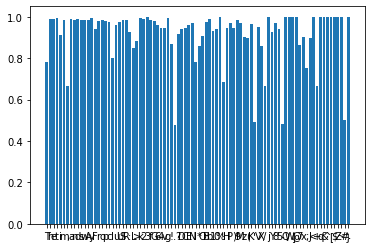

In [ ]:
sorted_letter_probabilties = sorted(letter_probabilties.items(), key=lambda x:x[1])
print(sorted_letter_probabilties)
plt.bar(list(letter_probabilties.keys()), letter_probabilties.values())
plt.show()

###classifing with optimization on the train set


In [12]:
train_images_len = round(len(im_names) * 0.8)
with open('/content/model/letters_probabilty.json', 'r') as openfile:
  letter_probabilties = json.load(openfile)
success = 0
not_success = 0

for im in im_names[:train_images_len]:

  i = 0
  img = db['data'][im][:]
  font = db['data'][im].attrs['font']
  txt = db['data'][im].attrs['txt']
  charBB = db['data'][im].attrs['charBB']
  for word in txt:
    result = np.array([0,0,0,0,0])
    real_font = font[i].decode('UTF-8')
    for letter in word:
      try:
         proccessed_img = np.array(concentrateImg(img, charBB[:, :, i]))
         proccessed_img =  proccessed_img / 255
         proccessed_img =  proccessed_img.reshape(-1, 64, 64, 3)
      except:
        i += 1
        continue
      
      if letter_probabilties.get(chr(letter)) is not None:
        result += model(proccessed_img) * letter_probabilties[chr(letter)] / (2 - letter_probabilties[chr(letter)])
      i += 1

    predicted_font = find_name(np.argmax(result))
    for j in range (len(word)):
      if predicted_font == real_font:
        success += 1
      else:
        not_success += 1

win = (success / (success + not_success)) * 100
print(f'success rate is: {win}%')

success rate is: 99.5440354912915%


### classifing with optimization on the validation set

In [13]:
with open('/content/model/letters_probabilty.json', 'r') as openfile:
  letter_probabilties = json.load(openfile)

success = 0
not_success = 0


for im in im_names[train_images_len:]:
  i = 0
  img = db['data'][im][:]
  font = db['data'][im].attrs['font']
  txt = db['data'][im].attrs['txt']
  charBB = db['data'][im].attrs['charBB']
  for word in txt:
    result = np.array([0,0,0,0,0])
    real_font = font[i].decode('UTF-8')
    for letter in word:
      try:
         proccessed_img = np.array(concentrateImg(img, charBB[:, :, i]))
         proccessed_img =  proccessed_img / 255
         proccessed_img =  proccessed_img.reshape(-1, 64, 64, 3)
      except:
        i += 1
        continue
      
      if letter_probabilties.get(chr(letter)) is not None:
        result += model(proccessed_img) * letter_probabilties[chr(letter)] / (2 - letter_probabilties[chr(letter)])
      i += 1

    predicted_font = find_name(np.argmax(result))
    for j in range (len(word)):
      if predicted_font == real_font:
        success += 1
      else:
        not_success += 1

win = (success / (success + not_success)) * 100
print(f'success rate is: {win}%')

success rate is: 95.49870466321244%


###viewing success rate by font

In [22]:
success_font = defaultdict(int)
fail_font= defaultdict(int)

for im in im_names[train_images_len:]:

  i = 0
  img = db['data'][im][:]
  font = db['data'][im].attrs['font']
  txt = db['data'][im].attrs['txt']
  charBB = db['data'][im].attrs['charBB']
  for word in txt:
    result = np.array([0,0,0,0,0])
    real_font = font[i].decode('UTF-8')
    for letter in word:
      try:
         proccessed_img = np.array(concentrateImg(img, charBB[:, :, i]))
         proccessed_img =  proccessed_img / 255
         proccessed_img =  proccessed_img.reshape(-1, 64, 64, 3)
      except:
        i += 1
        continue
      
      if letter_probabilties.get(chr(letter)) is not None:
        result += model(proccessed_img) * letter_probabilties[chr(letter)] / (2 - letter_probabilties[chr(letter)])
      i += 1

    predicted_font = find_name(np.argmax(result))
    for j in range(len(word)):
      if predicted_font == real_font:
        success_font[real_font] += 1
      else:
        fail_font[real_font] += 1

font_probabilty = {k: success_font[k]/(success_font[k] + fail_font[k])for k in success_font}

###plot the fonts success probabilties

In [23]:
print(sorted(font_probabilty.items(), key=lambda x:x[1]))

[('Open Sans', 0.8736318407960199), ('Sansation', 0.9486552567237164), ('Titillium Web', 0.9650735294117647), ('Ubuntu Mono', 0.9762917933130699), ('Alex Brush', 0.990916597853014)]


<class 'dict'>


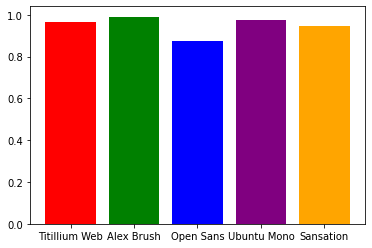

In [24]:
plt.bar(list(font_probabilty.keys()), font_probabilty.values(), color=['red', 'green', 'blue', 'purple' , 'orange'])
print(type(font_probabilty))

## Classifying and creating csv file with the given h5 file

In [26]:
# loading the dataset:
db = h5py.File('/content/drive/MyDrive/SynthText_test.h5')
im_names = list(db['data'].keys())

df = {'image': [], 'char': [], "Open Sans": [], "Sansation": [], "Titillium Web": [],
      "Ubuntu Mono": [], "Alex Brush": []}

# loading the probability letter dictionary file:
with open('/content/model/letters_probabilty.json', 'r') as openfile:
  letter_probabilties = json.load(openfile)

# loading the model:

with open('/content/model/model.json', 'r') as json_file:
  json_model = json_file.read()
model = model_from_json(json_model,custom_objects={'RandomColorDistortion':RandomColorDistortion})
model.load_weights('/content/model/model.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

for im in im_names[:]:
  i = 0
  img = db['data'][im][:]
  txt = db['data'][im].attrs['txt']
  charBB = db['data'][im].attrs['charBB']
  for word in txt:
    result = np.array([0,0,0,0,0])
    for letter in word:
      df['image'].append(str(im))
      df['char'].append(chr(letter))
      try:
         proccessed_img = np.array(concentrateImg(img, charBB[:, :, i]))
         proccessed_img =  proccessed_img / 255
         proccessed_img =  proccessed_img.reshape(-1, 64, 64, 3)
      except:
        i += 1
        continue
      if letter_probabilties.get(chr(letter)) is not None:
        result += model(proccessed_img) * letter_probabilties[chr(letter)] / (2 - letter_probabilties[chr(letter)])
      i += 1
    
    predicted_font = find_name(np.argmax(result))
    
    # add the result to the data frame
    for j in range(len(word)):
      df['Alex Brush'].append(1 if predicted_font == 'Alex Brush' else 0)
      df['Open Sans'].append(1 if predicted_font == 'Open Sans' else 0)
      df['Sansation'].append(1 if predicted_font == 'Sansation' else 0)
      df['Titillium Web'].append(1 if predicted_font == 'Titillium Web' else 0)
      df['Ubuntu Mono'].append(1 if predicted_font == 'Ubuntu Mono' else 0)

df = pd.DataFrame(df)
df.to_csv('font_predictions.csv')

##Conclusion
I learned alot from making this project.

The model has room for improvement, but overall performance is impressive.Thank you for reading! 😀